In [78]:
# 각종 라이브러리~

import os
import json
import pandas as pd
import glob
from glob import glob 
import torch
import random

from tqdm import tqdm
from PIL import Image

from torch.utils.data import Dataset
from torchvision import transforms
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.datasets import ImageFolder
import torch.nn.functional as F

from matplotlib import font_manager, rc

#### **데이터 불균형 확인**

In [3]:
plt.rcParams['font.family'] = 'Malgun Gothic' # 한글 폰트 설정 
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 라벨별 통계 그래프 그리기
def label_graph(data_root):
    label_stats = {}

    for label in os.listdir(data_root):
        label_path = os.path.join(data_root, label)
        if not os.path.isdir(label_path):
            continue

        video_folders = [d for d in os.listdir(label_path)
                         if os.path.isdir(os.path.join(label_path, d))]
        video_count = len(video_folders)
        image_count = 0

        for video in video_folders:
            video_path = os.path.join(label_path, video)
            image_files = [f for f in os.listdir(video_path)
                           if os.path.isfile(os.path.join(video_path, f)) and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            image_count += len(image_files)

        label_stats[label] = {'video_count': video_count, 'image_count': image_count}

    labels = list(label_stats.keys())
    video_counts = [label_stats[label]['video_count'] for label in labels]
    image_counts = [label_stats[label]['image_count'] for label in labels]

    fig, ax1 = plt.subplots(figsize=(15, 8))

    bar_color = '#4C72B0'
    line_color = '#FF7F0E'

    # 이미지 수 막대그래프
    bars = ax1.bar(labels, image_counts, color=bar_color, label='이미지 수')
    ax1.set_xlabel('라벨명')
    ax1.set_ylabel('이미지 수', color=bar_color)
    ax1.tick_params(axis='y', labelcolor=bar_color)

    # 이미지 수 위에 숫자 표시
    for bar in bars:
        x = bar.get_x() + bar.get_width() * 0.5
        y = bar.get_height()
        ax1.text(x, y + 0.01 * max(image_counts), f'{int(y)}', ha='center', va='bottom',
                 fontsize=9, fontweight='bold', color=bar_color)

    # 동영상 수 선그래프
    ax2 = ax1.twinx()
    ax2.plot(labels, video_counts, color=line_color, marker='o', label='동영상 수')
    ax2.set_ylabel('동영상 수', color=line_color)
    ax2.tick_params(axis='y', labelcolor=line_color)

    # X축 라벨 회전
    ax1.set_xticks(range(len(labels)))
    ax1.set_xticklabels(labels, rotation=75, ha='right', fontsize=9)

    plt.title('EMOTION 라벨별 이미지 수/동영상 수')
    plt.subplots_adjust(bottom=0.35)
    plt.tight_layout()
    plt.show()


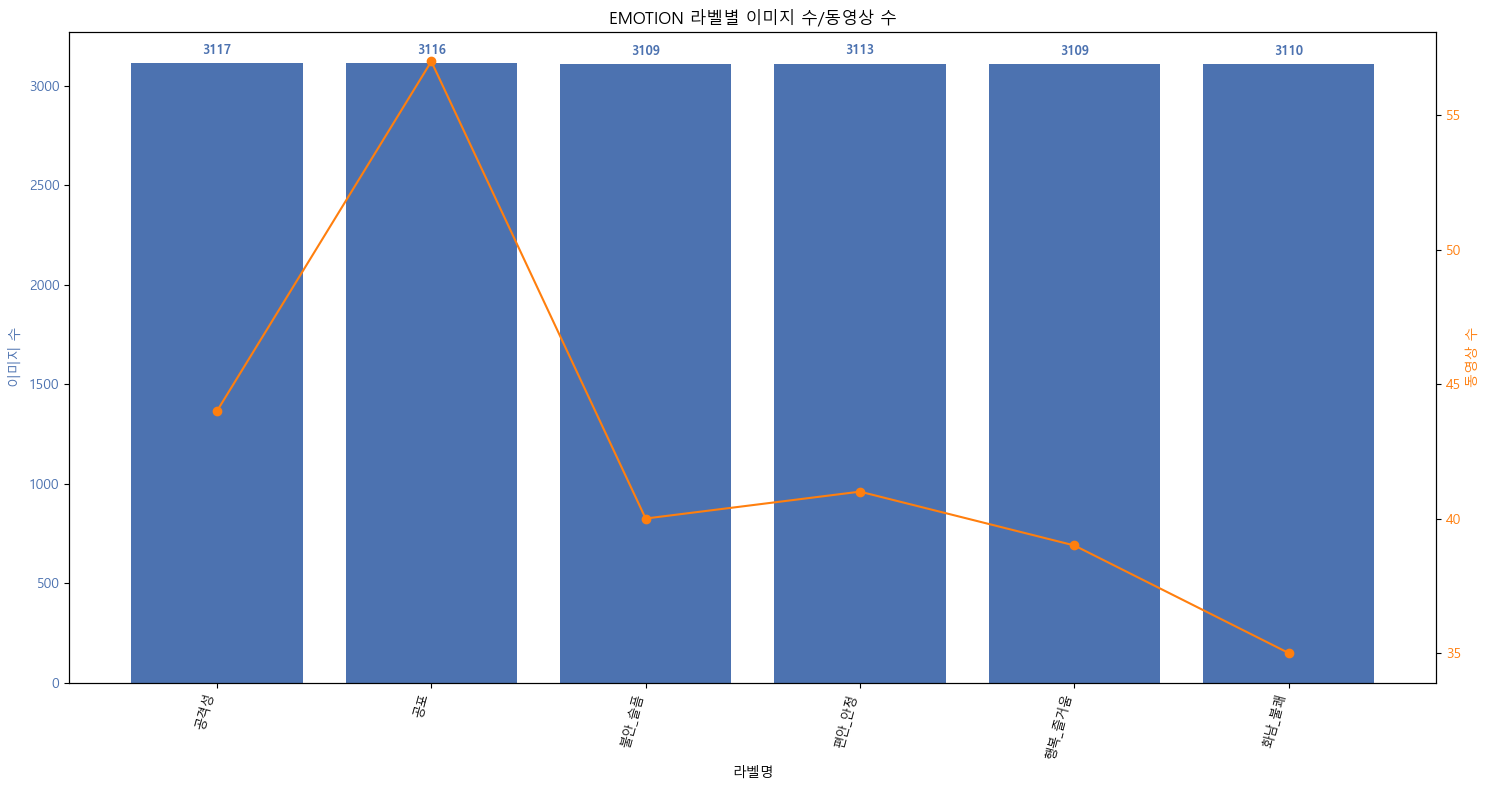

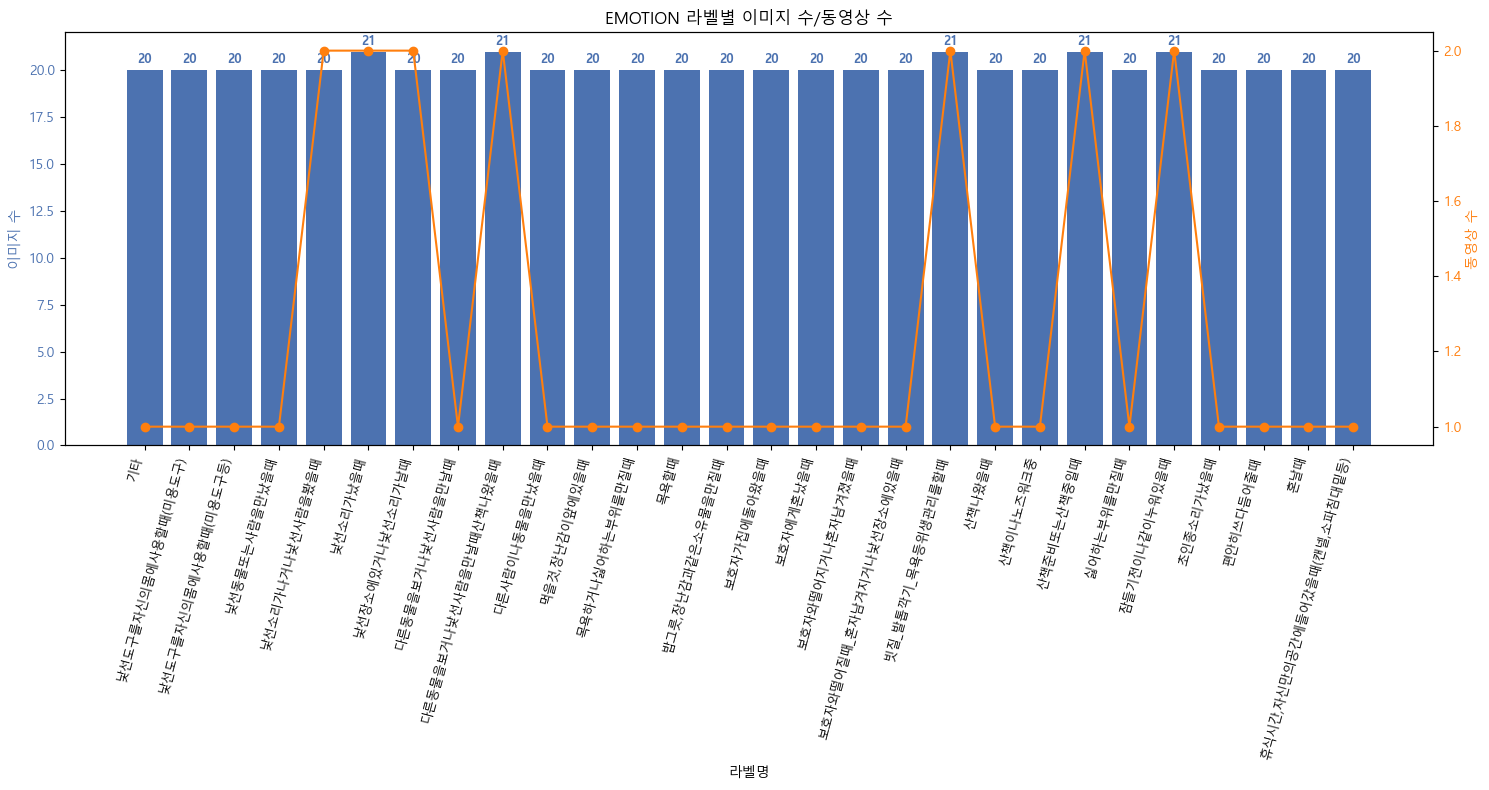

In [4]:
label_graph(r"C:\Users\SYR\Desktop\AI\emotion")
label_graph(r"C:\Users\SYR\Desktop\AI\situation")


#### **TEST SET 분리**

In [2]:
import os
import shutil
import random
from pathlib import Path

def split_test_set(input_dir, output_dir, test_ratio=0.2, move=False):
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for label in os.listdir(input_dir):
        label_path = input_dir / label
        if not label_path.is_dir():
            continue

        for video_folder in os.listdir(label_path):
            video_path = label_path / video_folder
            if not video_path.is_dir():
                continue

            # 이미지 목록 불러오기
            images = [f for f in os.listdir(video_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            if not images:
                continue

            # 테스트 셋 개수 계산
            test_size = max(1, int(len(images) * test_ratio))
            test_images = random.sample(images, test_size)

            # 출력 경로 설정
            out_path = output_dir / label / video_folder
            out_path.mkdir(parents=True, exist_ok=True)

            for img in test_images:
                src = video_path / img
                dst = out_path / img
                if move:
                    shutil.move(str(src), str(dst))
                else:
                    shutil.copy2(str(src), str(dst))

    print(f"TEST 셋 분리 완료 ({'이동' if move else '복사'} 완료)")

In [4]:
input = r"C:\Users\yura\Desktop\AI\emotion"
output = r"C:\Users\yura\Desktop\AI\emotion_test"
split_test_set(input, output, test_ratio=0.2, move=True)


TEST 셋 분리 완료 (이동 완료)


#### **YOLO**

In [211]:
!pip install ultralytics


   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 16.5 MB/s eta 0:00:00

   -------------------------- ------------- 2/3 [ultralytics]
   -------------------------- ------------- 2/3 [ultralytics]
   -------------------------- ------------- 2/3 [ultralytics]
   ---------------------------------------- 3/3 [ultralytics]



In [ ]:
import os
import sys
import contextlib
from ultralytics import YOLO
from PIL import Image

# 경로 설정
input_root = r"C:\Users\yura\Desktop\AI\Inference"
output_root = r"C:\Users\yura\Desktop\AI\Inference_faces"

os.makedirs(output_root, exist_ok=True)

# YOLO 모델 로드
model = YOLO("yolov8n.pt")
cat_class_id = 15  # COCO 기준 고양이 class

# 카운터
total_images = 0
total_missed = 0

# YOLO 출력 억제
@contextlib.contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

# 전체 라벨/비디오 폴더 순회
for label_name in os.listdir(input_root):
    label_path = os.path.join(input_root, label_name)
    if not os.path.isdir(label_path):
        continue

    for video_folder in os.listdir(label_path):
        video_path = os.path.join(label_path, video_folder)
        if not os.path.isdir(video_path):
            continue

        for fname in os.listdir(video_path):
            if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue

            total_images += 1
            img_path = os.path.join(video_path, fname)
            try:
                img = Image.open(img_path).convert("RGB")
            except Exception as e:
                print(f"[⚠️ 읽기 실패] {img_path}: {e}")
                total_missed += 1
                continue

            # YOLO 추론
            with suppress_stdout():
                results = model(img)

            found = False
            for box in results[0].boxes.data:
                cls_id = int(box[5])
                if cls_id == cat_class_id:
                    x1, y1, x2, y2 = box[:4].cpu().numpy().astype(int)
                    face = img.crop((x1, y1, x2, y2))

                    # 저장 경로 구성
                    save_dir = os.path.join(output_root, label_name, video_folder)
                    os.makedirs(save_dir, exist_ok=True)
                    face.save(os.path.join(save_dir, fname))
                    found = True
                    break

            if not found:
                total_missed += 1

# ✅ 결과 출력
print(f"\n🐾 전체 이미지 수: {total_images}장")
print(f"❌ 고양이 미검출 이미지 수: {total_missed}장")


0: 640x384 1 person, 1 cat, 1 bottle, 1 bowl, 1 sink, 32.1ms
Speed: 5.5ms preprocess, 32.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 cat, 1 bottle, 1 bowl, 1 sink, 30.1ms
Speed: 2.4ms preprocess, 30.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 cat, 1 bottle, 1 bowl, 1 sink, 40.2ms
Speed: 4.1ms preprocess, 40.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 cat, 1 bowl, 1 sink, 5.2ms
Speed: 3.0ms preprocess, 5.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 cat, 1 bottle, 1 bowl, 4.5ms
Speed: 1.4ms preprocess, 4.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 cat, 1 bottle, 1 sink, 4.9ms
Speed: 1.3ms preprocess, 4.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 cat, 1 bottle, 1 sink, 5.1ms
Speed: 1.2ms preprocess, 

#### **Label 정리**

In [ ]:
# Situation 중복 라벨 있음! 정리 필요

def map_situation(text):
    try:
        text_clean = text.replace("(", "").replace(")", "").replace(" ", "")
    except:
        print(f"[Error] '{text}' → 문자열 아님")
        return "라벨 확인 필요"

    if "기타" in text_clean:
        return "기타"
    elif "낯선도구" in text_clean:
        return "낯선 도구를 자신의 몸에 사용할 때"
    elif any(kw in text_clean for kw in ["낯선소리", "낯선장소", "낯선사람", "낯선동물", "다른사람"]):
        return "낯선 상황을 마주했을 때"
    elif any(kw in text_clean for kw in ["먹을것", "장난감", "밥그릇"]):
        return "먹을것이나 장난감이 앞에 있을 때"
    elif "싫어하는부위" in text_clean:
        return "싫어하는 부위를 만질 때"
    elif "목욕" in text_clean:
        return "목욕할 때"
    elif "산책" in text_clean:
        return "산책 준비, 또는 산책 나왔을 때"
    elif "휴식시간" in text_clean or "자신만의공간" in text_clean:
        return "휴식시간, 자신만의 공간에 들어갔을 때"
    elif "편안히" in text_clean:
        return "편안히 쓰다듬어 줄 때"
    elif any(kw in text_clean for kw in ["혼났을때", "혼날때"]):
        return "보호자에게 혼나고 있을 때"
    elif "보호자가집에돌아왔을때" in text_clean:
        return "보호자가 집에 돌아왔을 때"
    elif "보호자와떨어지거나" in text_clean or "혼자남겨지거나" in text_clean:
        return "보호자와 떨어지거나 혼자 남겨졌을 때"
    elif "잠들기전" in text_clean or "같이누워있을때" in text_clean:
        return "잠들기 전이나 같이 누워있을 때"
    elif "차에타있을때" in text_clean:
        return "차에 타 있을 때"
    elif "초인종소리" in text_clean:
        return "초인종 소리가 났을 때"
    else:
        print(f"[Unmapped] '{text}' → 라벨 확인 필요")
        return "라벨 확인 필요"  # 혹시 변환 안 된 라벨이 있는지 확인!



#### **라벨링**

In [ ]:
# # json 파일을 기준으로 라벨 생성

# class json_label(Dataset):
#     def __init__(self, image_root, json_root, transform=None, label_mapper=None, mode="situation"):
#         self.samples = []
#         self.transform = transform
#         self.label_mapper = label_mapper
#         self.label_to_idx = {}
#         self.idx_to_label = {}
#         self.mode = mode  # ← 이 줄 추가

#         for root, _, files in os.walk(json_root):
#             for file in files:
#                 if not file.endswith(".json"):
#                     continue

#                 json_path = os.path.join(root, file)
#                 video_name = os.path.splitext(file)[0]

#                 with open(json_path, 'r', encoding='utf-8') as f:
#                     data = json.load(f)

#                 # Emotion/Situation 구분
#                 if self.mode == "emotion":
#                     raw_label = data.get("metadata", {}).get("inspect", {}).get("emotion", "라벨 없음")
#                 else:
#                     raw_label = data.get("metadata", {}).get("owner", {}).get("situation", "라벨 없음")

#                 label = self.label_mapper(raw_label) if self.label_mapper else raw_label

#                 if label not in self.label_to_idx:
#                     idx = len(self.label_to_idx)
#                     self.label_to_idx[label] = idx
#                     self.idx_to_label[idx] = label

#                 video_folder = self._find_image_folder(image_root, video_name)
#                 if not video_folder:
#                     continue

#                 for img_name in os.listdir(video_folder):
#                     if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
#                         continue
#                     img_path = os.path.join(video_folder, img_name)
#                     self.samples.append((img_path, self.label_to_idx[label]))

#     def _find_image_folder(self, image_root, video_name):
#         for label_folder in os.listdir(image_root):
#             label_path = os.path.join(image_root, label_folder)
#             if not os.path.isdir(label_path):
#                 continue
#             video_path = os.path.join(label_path, video_name)
#             if os.path.isdir(video_path):
#                 return video_path
#         return None

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         img_path, label = self.samples[idx]
#         image = Image.open(img_path).convert("RGB")
#         if self.transform:
#             image = self.transform(image)
#         return image, label

In [222]:
# 폴더 기준으로 라벨 생성

import os
from PIL import Image
from torch.utils.data import Dataset

class FolderLabelDataset(Dataset):
    def __init__(self, image_root, transform=None, label_mapper=None):
        self.samples = []
        self.transform = transform
        self.label_mapper = label_mapper

        self.label_to_idx = {}
        self.idx_to_label = {}

        for label_folder in os.listdir(image_root):
            label_path = os.path.join(image_root, label_folder)
            if not os.path.isdir(label_path):
                continue

            label = self.label_mapper(label_folder) if self.label_mapper else label_folder

            if label not in self.label_to_idx:
                idx = len(self.label_to_idx)
                self.label_to_idx[label] = idx
                self.idx_to_label[idx] = label

            for video_folder in os.listdir(label_path):
                video_path = os.path.join(label_path, video_folder)
                if not os.path.isdir(video_path):
                    continue

                for img_file in os.listdir(video_path):
                    if img_file.lower().endswith((".jpg", ".jpeg", ".png")):
                        img_path = os.path.join(video_path, img_file)
                        self.samples.append((img_path, self.label_to_idx[label]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [281]:
from collections import Counter
import matplotlib.pyplot as plt

def show_label_distribution(dataset):
    label_counter = Counter()
    
    # 정수 인덱스를 라벨 문자열로 변환하여 카운트
    for _, label_idx in dataset.samples:
        label_name = dataset.idx_to_label[label_idx]
        label_counter[label_name] += 1

    # 정렬된 라벨 기준으로 시각화
    labels = list(label_counter.keys())
    counts = [label_counter[label] for label in labels]

    plt.figure(figsize=(6, 5))
    bars = plt.bar(labels, counts)
    plt.ylabel("이미지 수")
    plt.title("라벨별 이미지 분포")
    plt.xticks(rotation=45, ha='right')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{int(height)}",
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

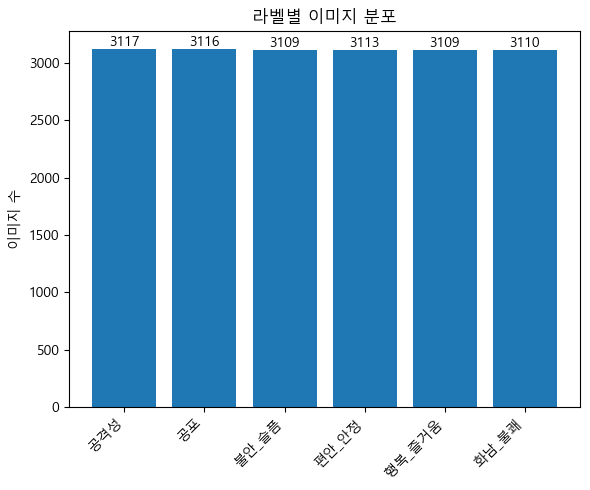

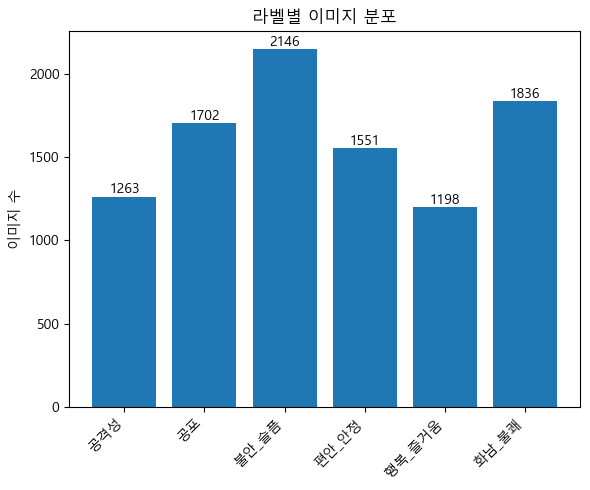

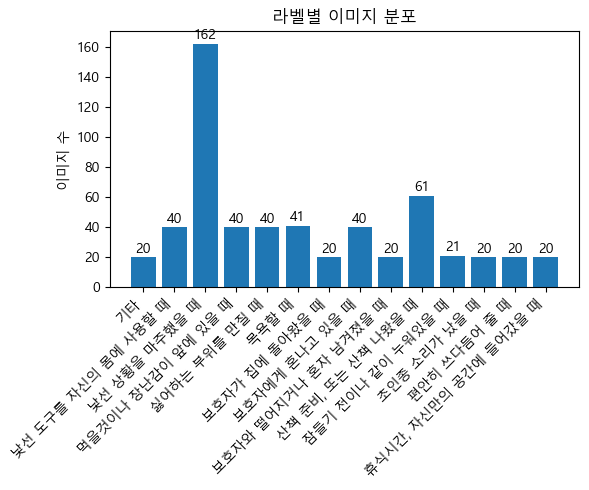

In [282]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 감정 데이터셋 (라벨 매핑 없음)
emotion_dataset = FolderLabelDataset(
    image_root=r"C:\Users\yura\Desktop\AI\emotion",
    transform=transform
)
show_label_distribution(emotion_dataset)

# 감정 데이터셋 (라벨 매핑 없음)
emotion_dataset_faces = FolderLabelDataset(
    image_root=r"C:\Users\yura\Desktop\AI\emotion_faces",
    transform=transform
)
show_label_distribution(emotion_dataset_faces)

# 상황 데이터셋 (map_situation으로 라벨 매핑)
situation_dataset = FolderLabelDataset(
    image_root=r"C:\Users\yura\Desktop\AI\situation",
    transform=transform,
    label_mapper=map_situation
)
show_label_distribution(situation_dataset)

#### **모델 학습**

In [ ]:
# 데이터 로더
def get_train_val_dataloaders_from_folder(
    image_root,
    val_ratio=0.2,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    seed=777,
    label_mapper=None
):
    torch.manual_seed(seed)
    random.seed(seed)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # 폴더 기반 데이터셋 사용
    dataset = FolderLabelDataset(
        image_root=image_root,
        transform=transform,
        label_mapper=label_mapper
    )

    total_size = len(dataset)
    val_size = int(total_size * val_ratio)
    train_size = total_size - val_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    print(f"전체 {total_size}개 중 학습 {train_size}개, 검증 {val_size}개로 분리 완료.")
    return train_loader, val_loader, list(dataset.label_to_idx.keys())

In [30]:
# ResNet18 학습
def train_model(train_loader, val_loader, class_names, num_epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, len(class_names))
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f"\n[Epoch {epoch+1}/{num_epochs}] 시작!")

        model.train()
        total_loss, total_correct = 0, 0
        loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for i, (inputs, labels) in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            # if i < 5:  # 초기 5개 배치 디버깅용 출력
            #     print(f"[Batch {i}] inputs.shape: {inputs.shape}, labels.shape: {labels.shape}, labels (min-max): {labels.min().item()} ~ {labels.max().item()}")

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader.dataset)
        accuracy = total_correct / len(train_loader.dataset)

        # 검증 단계
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        history["train_loss"].append(avg_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(accuracy)
        history["val_acc"].append(val_acc)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_loss:.4f}, Acc: {accuracy:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    return model, history

In [156]:
# ResNet50 학습

from torchvision.models import resnet50, ResNet50_Weights

def train_model_resnet50(train_loader, val_loader, class_names, num_epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ✅ ResNet50으로 변경
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, len(class_names))
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f"\n[Epoch {epoch+1}/{num_epochs}] 시작!")

        model.train()
        total_loss, total_correct = 0, 0
        loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for i, (inputs, labels) in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader.dataset)
        accuracy = total_correct / len(train_loader.dataset)

        # 검증 단계
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        history["train_loss"].append(avg_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(accuracy)
        history["val_acc"].append(val_acc)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_loss:.4f}, Acc: {accuracy:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    return model, history

In [ ]:
# EfficientNet-b4

from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

def train_model_efficient(train_loader, val_loader, class_names, num_epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # EfficientNet-B4 불러오기
    model = efficientnet_b4(weights=EfficientNet_B4_Weights.DEFAULT)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(class_names))
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f"\n[Epoch {epoch+1}/{num_epochs}] 시작!")

        model.train()
        total_loss, total_correct = 0, 0
        loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for i, (inputs, labels) in loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader.dataset)
        accuracy = total_correct / len(train_loader.dataset)

        # 검증 단계
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        history["train_loss"].append(avg_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(accuracy)
        history["val_acc"].append(val_acc)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_loss:.4f}, Acc: {accuracy:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    return model, history


In [277]:
# Emotion
train_loader_emotion, val_loader_emotion, class_names_emotion = get_train_val_dataloaders_from_folder(
    image_root=r"C:\Users\yura\Desktop\AI\emotion",  
    batch_size=16,
    seed=777,
    label_mapper=None,  
    num_workers=0
)

# Emotion
train_loader_emotion_faces, val_loader_emotion_faces, class_names_emotion_faces = get_train_val_dataloaders_from_folder(
    image_root=r"C:\Users\yura\Desktop\AI\emotion_faces",  
    batch_size=16,
    seed=777,
    label_mapper=None,  
    num_workers=0
)

전체 18674개 중 학습 14940개, 검증 3734개로 분리 완료.
전체 9696개 중 학습 7757개, 검증 1939개로 분리 완료.


In [40]:
# Situation
train_loader_situation, val_loader_situation, class_names_situation = get_train_val_dataloaders_from_folder(
    image_root=r"C:\Users\yura\Desktop\AI\situation",
    batch_size=16,
    seed=777,
    label_mapper=map_situation,
    num_workers=0
)

전체 565개 중 학습 452개, 검증 113개로 분리 완료.


In [41]:
def plot_history(history, title_prefix=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(14, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Loss Over Epochs")
    plt.legend()
    plt.grid(True)

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [229]:
model_emotion, history_emotion = train_model(
    train_loader_emotion, val_loader_emotion, class_names_emotion,
    num_epochs=10, lr=0.001
)


[Epoch 1/10] 시작!


Epoch 1/10: 100%|██████████| 485/485 [00:48<00:00, 10.04it/s, loss=0.383] 


[Epoch 1] Train Loss: 0.7303, Acc: 0.7540 | Val Loss: 0.5702, Acc: 0.8216

[Epoch 2/10] 시작!


Epoch 2/10: 100%|██████████| 485/485 [00:46<00:00, 10.35it/s, loss=0.444] 


[Epoch 2] Train Loss: 0.3256, Acc: 0.8913 | Val Loss: 0.4855, Acc: 0.8633

[Epoch 3/10] 시작!


Epoch 3/10: 100%|██████████| 485/485 [00:47<00:00, 10.26it/s, loss=0.125]  


[Epoch 3] Train Loss: 0.1946, Acc: 0.9361 | Val Loss: 0.1479, Acc: 0.9541

[Epoch 4/10] 시작!


Epoch 4/10: 100%|██████████| 485/485 [00:48<00:00, 10.01it/s, loss=0.0444] 


[Epoch 4] Train Loss: 0.1845, Acc: 0.9384 | Val Loss: 0.1904, Acc: 0.9397

[Epoch 5/10] 시작!


Epoch 5/10: 100%|██████████| 485/485 [00:46<00:00, 10.37it/s, loss=0.067]   


[Epoch 5] Train Loss: 0.1247, Acc: 0.9581 | Val Loss: 0.2578, Acc: 0.9195

[Epoch 6/10] 시작!


Epoch 6/10: 100%|██████████| 485/485 [00:46<00:00, 10.40it/s, loss=0.0773]  


[Epoch 6] Train Loss: 0.0936, Acc: 0.9692 | Val Loss: 0.2951, Acc: 0.9299

[Epoch 7/10] 시작!


Epoch 7/10: 100%|██████████| 485/485 [00:46<00:00, 10.42it/s, loss=0.0103]  


[Epoch 7] Train Loss: 0.0874, Acc: 0.9715 | Val Loss: 0.2836, Acc: 0.9381

[Epoch 8/10] 시작!


Epoch 8/10: 100%|██████████| 485/485 [00:46<00:00, 10.39it/s, loss=0.0645]  


[Epoch 8] Train Loss: 0.0860, Acc: 0.9715 | Val Loss: 0.5411, Acc: 0.8551

[Epoch 9/10] 시작!


Epoch 9/10: 100%|██████████| 485/485 [00:46<00:00, 10.34it/s, loss=0.154]   


[Epoch 9] Train Loss: 0.0965, Acc: 0.9687 | Val Loss: 0.2262, Acc: 0.9453

[Epoch 10/10] 시작!


Epoch 10/10: 100%|██████████| 485/485 [00:46<00:00, 10.39it/s, loss=0.0236]  


[Epoch 10] Train Loss: 0.0687, Acc: 0.9785 | Val Loss: 0.1603, Acc: 0.9660


In [231]:
model_emotion_res50, history_emotion_res50 = train_model_resnet50(
    train_loader_emotion, val_loader_emotion, class_names_emotion,
    num_epochs=10, lr=0.001
)


[Epoch 1/10] 시작!


Epoch 1/10: 100%|██████████| 485/485 [01:15<00:00,  6.43it/s, loss=0.189] 


[Epoch 1] Train Loss: 0.6387, Acc: 0.7855 | Val Loss: 0.4773, Acc: 0.8479

[Epoch 2/10] 시작!


Epoch 2/10: 100%|██████████| 485/485 [01:15<00:00,  6.43it/s, loss=0.0161] 


[Epoch 2] Train Loss: 0.2561, Acc: 0.9180 | Val Loss: 0.3487, Acc: 0.8871

[Epoch 3/10] 시작!


Epoch 3/10: 100%|██████████| 485/485 [01:15<00:00,  6.44it/s, loss=0.153]  


[Epoch 3] Train Loss: 0.1526, Acc: 0.9478 | Val Loss: 0.1728, Acc: 0.9510

[Epoch 4/10] 시작!


Epoch 4/10: 100%|██████████| 485/485 [01:15<00:00,  6.44it/s, loss=0.0872] 


[Epoch 4] Train Loss: 0.1206, Acc: 0.9611 | Val Loss: 0.7990, Acc: 0.7504

[Epoch 5/10] 시작!


Epoch 5/10: 100%|██████████| 485/485 [01:15<00:00,  6.43it/s, loss=0.154]   


[Epoch 5] Train Loss: 0.1125, Acc: 0.9645 | Val Loss: 0.2682, Acc: 0.9252

[Epoch 6/10] 시작!


Epoch 6/10: 100%|██████████| 485/485 [01:15<00:00,  6.40it/s, loss=0.0175]  


[Epoch 6] Train Loss: 0.0614, Acc: 0.9823 | Val Loss: 1.3715, Acc: 0.7045

[Epoch 7/10] 시작!


Epoch 7/10: 100%|██████████| 485/485 [01:15<00:00,  6.42it/s, loss=0.0233]  


[Epoch 7] Train Loss: 0.0714, Acc: 0.9765 | Val Loss: 0.2284, Acc: 0.9350

[Epoch 8/10] 시작!


Epoch 8/10: 100%|██████████| 485/485 [01:15<00:00,  6.41it/s, loss=0.00398] 


[Epoch 8] Train Loss: 0.0750, Acc: 0.9738 | Val Loss: 0.8276, Acc: 0.9237

[Epoch 9/10] 시작!


Epoch 9/10: 100%|██████████| 485/485 [01:15<00:00,  6.40it/s, loss=0.0378]  


[Epoch 9] Train Loss: 0.0389, Acc: 0.9885 | Val Loss: 0.2140, Acc: 0.9587

[Epoch 10/10] 시작!


Epoch 10/10: 100%|██████████| 485/485 [01:15<00:00,  6.41it/s, loss=0.0022]  


[Epoch 10] Train Loss: 0.0600, Acc: 0.9814 | Val Loss: 0.3357, Acc: 0.9376


In [278]:
model_emotion_eff, history_emotion_eff = train_model_efficient(
    train_loader_emotion, val_loader_emotion, class_names_emotion,
    num_epochs=10, lr=0.001
)


[Epoch 1/10] 시작!


Epoch 1/10: 100%|██████████| 934/934 [04:57<00:00,  3.14it/s, loss=0.000737]


[Epoch 1] Train Loss: 0.1996, Acc: 0.9341 | Val Loss: 0.0165, Acc: 0.9944

[Epoch 2/10] 시작!


Epoch 2/10: 100%|██████████| 934/934 [04:45<00:00,  3.27it/s, loss=0.0606]  


[Epoch 2] Train Loss: 0.0373, Acc: 0.9880 | Val Loss: 0.0314, Acc: 0.9890

[Epoch 3/10] 시작!


Epoch 3/10: 100%|██████████| 934/934 [05:00<00:00,  3.11it/s, loss=0.448]   


[Epoch 3] Train Loss: 0.0348, Acc: 0.9898 | Val Loss: 0.0140, Acc: 0.9960

[Epoch 4/10] 시작!


Epoch 4/10: 100%|██████████| 934/934 [04:54<00:00,  3.17it/s, loss=0.0109]  


[Epoch 4] Train Loss: 0.0422, Acc: 0.9869 | Val Loss: 0.0168, Acc: 0.9957

[Epoch 5/10] 시작!


Epoch 5/10: 100%|██████████| 934/934 [04:46<00:00,  3.26it/s, loss=0.00208] 


[Epoch 5] Train Loss: 0.0313, Acc: 0.9912 | Val Loss: 0.0741, Acc: 0.9829

[Epoch 6/10] 시작!


Epoch 6/10: 100%|██████████| 934/934 [04:53<00:00,  3.18it/s, loss=0.00353] 


[Epoch 6] Train Loss: 0.0244, Acc: 0.9930 | Val Loss: 0.0123, Acc: 0.9954

[Epoch 7/10] 시작!


Epoch 7/10: 100%|██████████| 934/934 [04:43<00:00,  3.30it/s, loss=0.00466] 


[Epoch 7] Train Loss: 0.0320, Acc: 0.9908 | Val Loss: 0.0213, Acc: 0.9949

[Epoch 8/10] 시작!


Epoch 8/10: 100%|██████████| 934/934 [04:36<00:00,  3.38it/s, loss=0.00229] 


[Epoch 8] Train Loss: 0.0188, Acc: 0.9943 | Val Loss: 0.0068, Acc: 0.9981

[Epoch 9/10] 시작!


Epoch 9/10: 100%|██████████| 934/934 [04:37<00:00,  3.36it/s, loss=0.00987] 


[Epoch 9] Train Loss: 0.0257, Acc: 0.9928 | Val Loss: 0.0199, Acc: 0.9968

[Epoch 10/10] 시작!


Epoch 10/10: 100%|██████████| 934/934 [04:49<00:00,  3.22it/s, loss=2.94e-5] 


[Epoch 10] Train Loss: 0.0202, Acc: 0.9942 | Val Loss: 0.0079, Acc: 0.9976


In [279]:
model_emotion_eff_yolo, history_emotion_eff_yolo = train_model_efficient(
    train_loader_emotion_faces, val_loader_emotion_faces, class_names_emotion_faces,
    num_epochs=10, lr=0.001


    
)


[Epoch 1/10] 시작!


Epoch 1/10: 100%|██████████| 485/485 [01:56<00:00,  4.15it/s, loss=0.157]  


[Epoch 1] Train Loss: 0.3805, Acc: 0.8730 | Val Loss: 0.0777, Acc: 0.9789

[Epoch 2/10] 시작!


Epoch 2/10: 100%|██████████| 485/485 [02:05<00:00,  3.87it/s, loss=0.0547]  


[Epoch 2] Train Loss: 0.0863, Acc: 0.9722 | Val Loss: 0.0590, Acc: 0.9825

[Epoch 3/10] 시작!


Epoch 3/10: 100%|██████████| 485/485 [01:43<00:00,  4.68it/s, loss=0.0355]  


[Epoch 3] Train Loss: 0.0590, Acc: 0.9825 | Val Loss: 0.0571, Acc: 0.9850

[Epoch 4/10] 시작!


Epoch 4/10: 100%|██████████| 485/485 [01:57<00:00,  4.13it/s, loss=0.109]   


[Epoch 4] Train Loss: 0.0544, Acc: 0.9822 | Val Loss: 0.0600, Acc: 0.9845

[Epoch 5/10] 시작!


Epoch 5/10: 100%|██████████| 485/485 [02:04<00:00,  3.89it/s, loss=0.0407]  


[Epoch 5] Train Loss: 0.0383, Acc: 0.9881 | Val Loss: 0.0764, Acc: 0.9778

[Epoch 6/10] 시작!


Epoch 6/10: 100%|██████████| 485/485 [02:01<00:00,  4.01it/s, loss=6.43e-5] 


[Epoch 6] Train Loss: 0.0487, Acc: 0.9848 | Val Loss: 0.0586, Acc: 0.9840

[Epoch 7/10] 시작!


Epoch 7/10: 100%|██████████| 485/485 [02:02<00:00,  3.95it/s, loss=0.00121] 


[Epoch 7] Train Loss: 0.0339, Acc: 0.9902 | Val Loss: 0.0424, Acc: 0.9881

[Epoch 8/10] 시작!


Epoch 8/10: 100%|██████████| 485/485 [02:03<00:00,  3.92it/s, loss=0.000866]


[Epoch 8] Train Loss: 0.0329, Acc: 0.9894 | Val Loss: 0.0490, Acc: 0.9892

[Epoch 9/10] 시작!


Epoch 9/10: 100%|██████████| 485/485 [02:02<00:00,  3.96it/s, loss=0.00763] 


[Epoch 9] Train Loss: 0.0513, Acc: 0.9865 | Val Loss: 0.1584, Acc: 0.9711

[Epoch 10/10] 시작!


Epoch 10/10: 100%|██████████| 485/485 [01:47<00:00,  4.50it/s, loss=0.000166]


[Epoch 10] Train Loss: 0.0390, Acc: 0.9885 | Val Loss: 0.0556, Acc: 0.9881


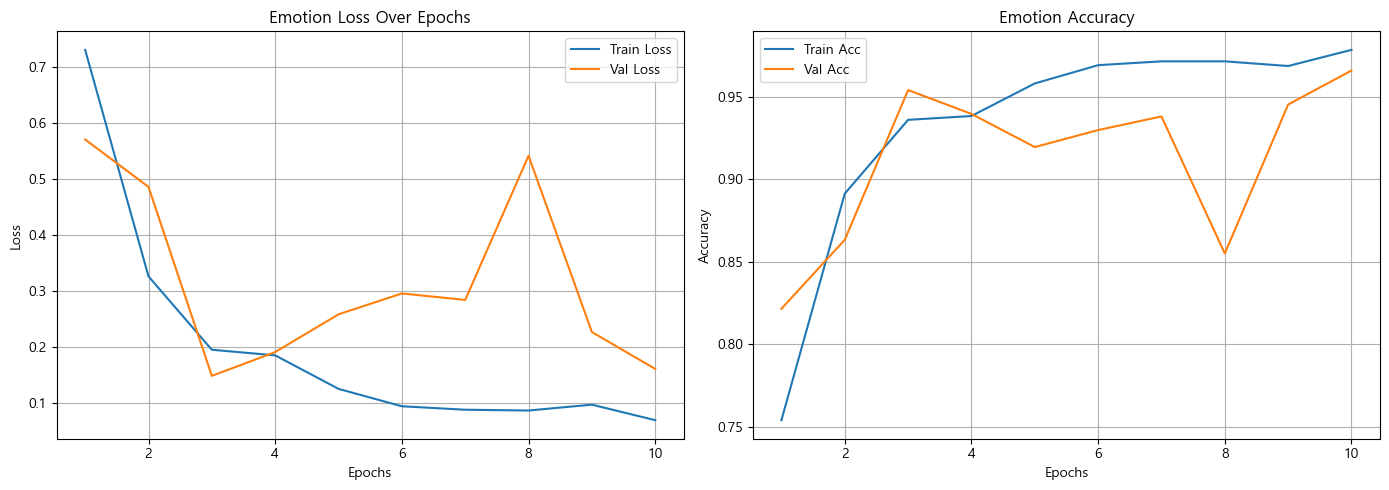

In [232]:
plot_history(history_emotion, title_prefix="Emotion")

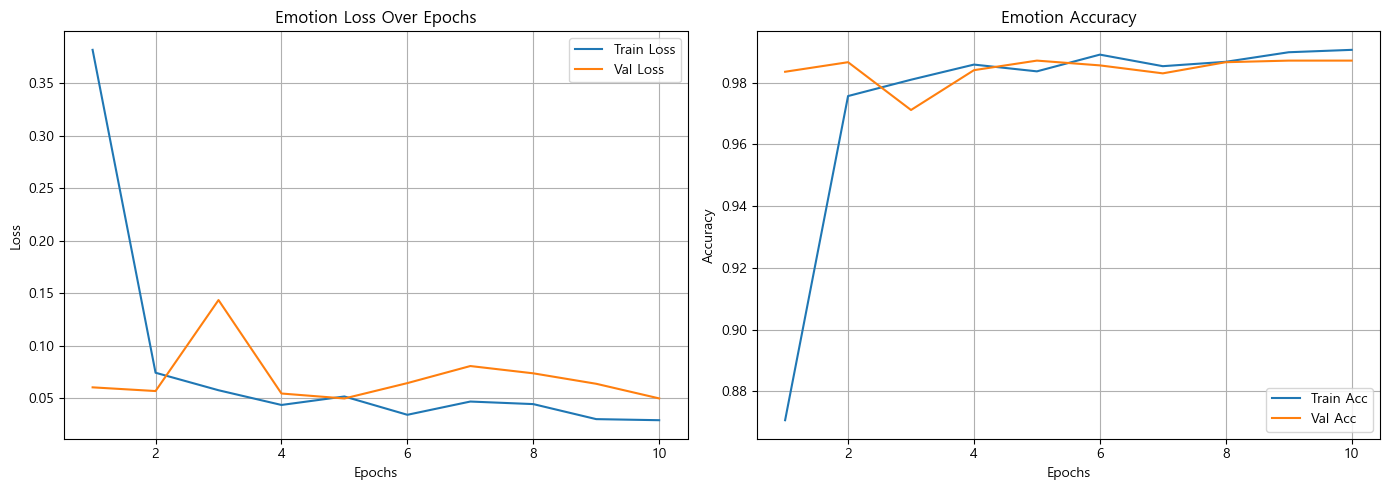

In [233]:
plot_history(history_emotion_eff, title_prefix="Emotion")

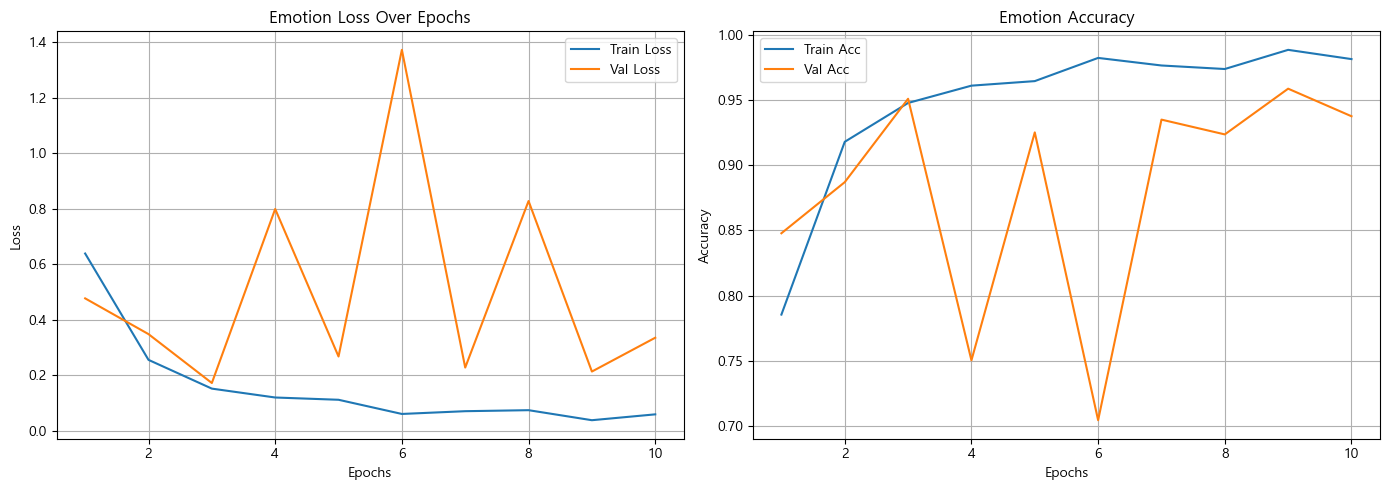

In [234]:
plot_history(history_emotion_res50, title_prefix="Emotion")

In [47]:
model_situation, history_situation = train_model(
    train_loader_situation, val_loader_situation, class_names_situation,
    num_epochs=10, lr=0.001
)


[Epoch 1/10] 시작!


Epoch 1/10: 100%|██████████| 29/29 [00:06<00:00,  4.72it/s, loss=0.74]  


[Epoch 1] Train Loss: 0.6099, Acc: 0.8385 | Val Loss: 3.2427, Acc: 0.4336

[Epoch 2/10] 시작!


Epoch 2/10: 100%|██████████| 29/29 [00:06<00:00,  4.63it/s, loss=1.63]  


[Epoch 2] Train Loss: 0.2313, Acc: 0.9469 | Val Loss: 0.3952, Acc: 0.9027

[Epoch 3/10] 시작!


Epoch 3/10: 100%|██████████| 29/29 [00:06<00:00,  4.55it/s, loss=0.242] 


[Epoch 3] Train Loss: 0.1083, Acc: 0.9712 | Val Loss: 0.3539, Acc: 0.8584

[Epoch 4/10] 시작!


Epoch 4/10: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s, loss=0.504]  


[Epoch 4] Train Loss: 0.0460, Acc: 0.9912 | Val Loss: 0.0287, Acc: 0.9823

[Epoch 5/10] 시작!


Epoch 5/10: 100%|██████████| 29/29 [00:06<00:00,  4.19it/s, loss=1.44]  


[Epoch 5] Train Loss: 0.1880, Acc: 0.9447 | Val Loss: 0.8732, Acc: 0.7257

[Epoch 6/10] 시작!


Epoch 6/10: 100%|██████████| 29/29 [00:06<00:00,  4.15it/s, loss=0.0293]


[Epoch 6] Train Loss: 0.1969, Acc: 0.9513 | Val Loss: 4.9565, Acc: 0.5929

[Epoch 7/10] 시작!


Epoch 7/10: 100%|██████████| 29/29 [00:06<00:00,  4.18it/s, loss=0.315]  


[Epoch 7] Train Loss: 0.0294, Acc: 0.9956 | Val Loss: 0.1088, Acc: 0.9735

[Epoch 8/10] 시작!


Epoch 8/10: 100%|██████████| 29/29 [00:06<00:00,  4.19it/s, loss=0.139]  


[Epoch 8] Train Loss: 0.0948, Acc: 0.9757 | Val Loss: 0.0233, Acc: 0.9912

[Epoch 9/10] 시작!


Epoch 9/10: 100%|██████████| 29/29 [00:06<00:00,  4.15it/s, loss=0.287]  


[Epoch 9] Train Loss: 0.0339, Acc: 0.9889 | Val Loss: 0.0009, Acc: 1.0000

[Epoch 10/10] 시작!


Epoch 10/10: 100%|██████████| 29/29 [00:06<00:00,  4.16it/s, loss=0.0232] 


[Epoch 10] Train Loss: 0.0457, Acc: 0.9889 | Val Loss: 0.0035, Acc: 1.0000


In [109]:
model_situation_eff, history_situation_eff = train_model_efficient(
    train_loader_situation, val_loader_situation, class_names_situation,
    num_epochs=10, lr=0.001
)


[Epoch 1/10] 시작!


Epoch 1/10: 100%|██████████| 29/29 [00:09<00:00,  3.14it/s, loss=1.45] 


[Epoch 1] Train Loss: 1.6139, Acc: 0.5686 | Val Loss: 0.4919, Acc: 0.9823

[Epoch 2/10] 시작!


Epoch 2/10: 100%|██████████| 29/29 [00:08<00:00,  3.34it/s, loss=0.0182] 


[Epoch 2] Train Loss: 0.1372, Acc: 0.9912 | Val Loss: 0.0141, Acc: 1.0000

[Epoch 3/10] 시작!


Epoch 3/10: 100%|██████████| 29/29 [00:09<00:00,  3.16it/s, loss=0.279]   


[Epoch 3] Train Loss: 0.0226, Acc: 0.9934 | Val Loss: 0.0425, Acc: 0.9912

[Epoch 4/10] 시작!


Epoch 4/10: 100%|██████████| 29/29 [00:09<00:00,  3.14it/s, loss=1.47]    


[Epoch 4] Train Loss: 0.0194, Acc: 0.9912 | Val Loss: 0.0025, Acc: 1.0000

[Epoch 5/10] 시작!


Epoch 5/10: 100%|██████████| 29/29 [00:09<00:00,  3.12it/s, loss=0.0615]  


[Epoch 5] Train Loss: 0.0321, Acc: 0.9978 | Val Loss: 0.0125, Acc: 1.0000

[Epoch 6/10] 시작!


Epoch 6/10: 100%|██████████| 29/29 [00:09<00:00,  3.13it/s, loss=0.00249] 


[Epoch 6] Train Loss: 0.0042, Acc: 1.0000 | Val Loss: 0.0081, Acc: 0.9912

[Epoch 7/10] 시작!


Epoch 7/10: 100%|██████████| 29/29 [00:09<00:00,  3.14it/s, loss=0.00385] 


[Epoch 7] Train Loss: 0.0051, Acc: 1.0000 | Val Loss: 0.0042, Acc: 1.0000

[Epoch 8/10] 시작!


Epoch 8/10: 100%|██████████| 29/29 [00:09<00:00,  3.12it/s, loss=0.0011]  


[Epoch 8] Train Loss: 0.0010, Acc: 1.0000 | Val Loss: 0.0045, Acc: 1.0000

[Epoch 9/10] 시작!


Epoch 9/10: 100%|██████████| 29/29 [00:09<00:00,  3.13it/s, loss=0.0119]  


[Epoch 9] Train Loss: 0.0012, Acc: 1.0000 | Val Loss: 0.0029, Acc: 1.0000

[Epoch 10/10] 시작!


Epoch 10/10: 100%|██████████| 29/29 [00:09<00:00,  3.13it/s, loss=0.00739] 


[Epoch 10] Train Loss: 0.0021, Acc: 1.0000 | Val Loss: 0.0230, Acc: 0.9912


In [185]:
model_situation_res50, history_situation_res50 = train_model_resnet50(
    train_loader_situation, val_loader_situation, class_names_situation,
    num_epochs=10, lr=0.001
)


[Epoch 1/10] 시작!


Epoch 1/10: 100%|██████████| 29/29 [00:07<00:00,  3.68it/s, loss=0.178] 


[Epoch 1] Train Loss: 0.6806, Acc: 0.8429 | Val Loss: 0.0572, Acc: 0.9735

[Epoch 2/10] 시작!


Epoch 2/10: 100%|██████████| 29/29 [00:07<00:00,  3.84it/s, loss=0.351]  


[Epoch 2] Train Loss: 0.0957, Acc: 0.9889 | Val Loss: 0.2298, Acc: 0.9204

[Epoch 3/10] 시작!


Epoch 3/10: 100%|██████████| 29/29 [00:07<00:00,  3.84it/s, loss=0.12]   


[Epoch 3] Train Loss: 0.1554, Acc: 0.9668 | Val Loss: 1.8755, Acc: 0.3274

[Epoch 4/10] 시작!


Epoch 4/10: 100%|██████████| 29/29 [00:07<00:00,  3.83it/s, loss=1.33]  


[Epoch 4] Train Loss: 0.2484, Acc: 0.9447 | Val Loss: 4.1161, Acc: 0.3982

[Epoch 5/10] 시작!


Epoch 5/10: 100%|██████████| 29/29 [00:07<00:00,  3.83it/s, loss=0.00376]


[Epoch 5] Train Loss: 0.2298, Acc: 0.9403 | Val Loss: 1.8893, Acc: 0.6460

[Epoch 6/10] 시작!


Epoch 6/10: 100%|██████████| 29/29 [00:07<00:00,  3.85it/s, loss=0.00427]


[Epoch 6] Train Loss: 0.1005, Acc: 0.9668 | Val Loss: 0.2122, Acc: 0.9381

[Epoch 7/10] 시작!


Epoch 7/10: 100%|██████████| 29/29 [00:07<00:00,  3.87it/s, loss=0.562]  


[Epoch 7] Train Loss: 0.0914, Acc: 0.9757 | Val Loss: 4.3507, Acc: 0.7080

[Epoch 8/10] 시작!


Epoch 8/10: 100%|██████████| 29/29 [00:07<00:00,  3.85it/s, loss=0.00863]


[Epoch 8] Train Loss: 0.1374, Acc: 0.9712 | Val Loss: 0.0482, Acc: 0.9912

[Epoch 9/10] 시작!


Epoch 9/10: 100%|██████████| 29/29 [00:07<00:00,  3.84it/s, loss=0.0574]  


[Epoch 9] Train Loss: 0.0298, Acc: 0.9889 | Val Loss: 0.0137, Acc: 1.0000

[Epoch 10/10] 시작!


Epoch 10/10: 100%|██████████| 29/29 [00:07<00:00,  3.83it/s, loss=0.00436] 


[Epoch 10] Train Loss: 0.0281, Acc: 0.9912 | Val Loss: 0.0145, Acc: 1.0000


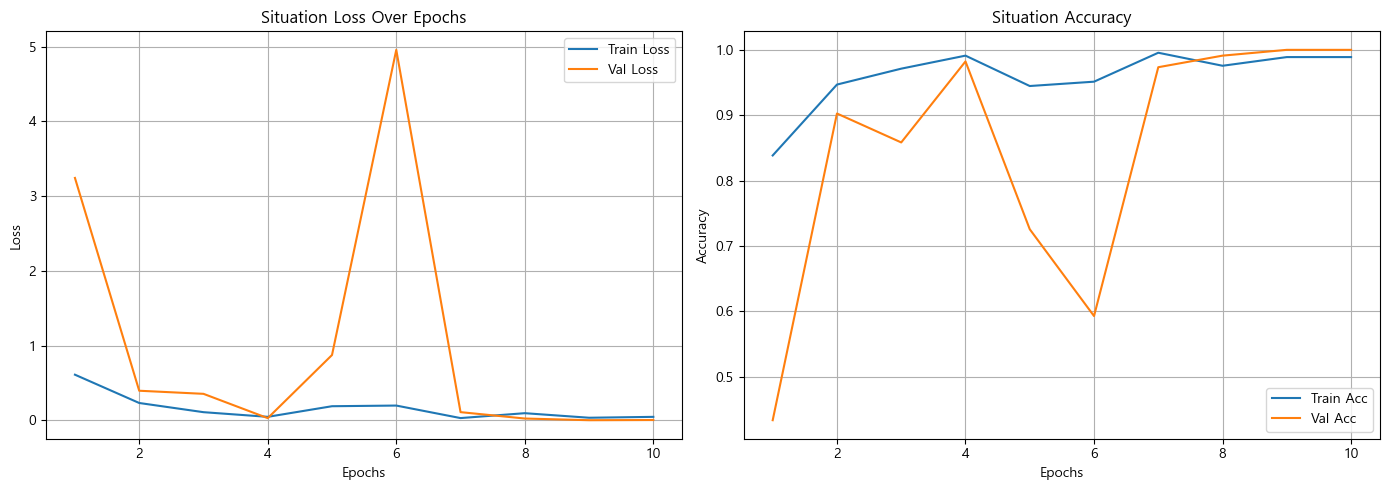

In [48]:
plot_history(history_situation, title_prefix="Situation")

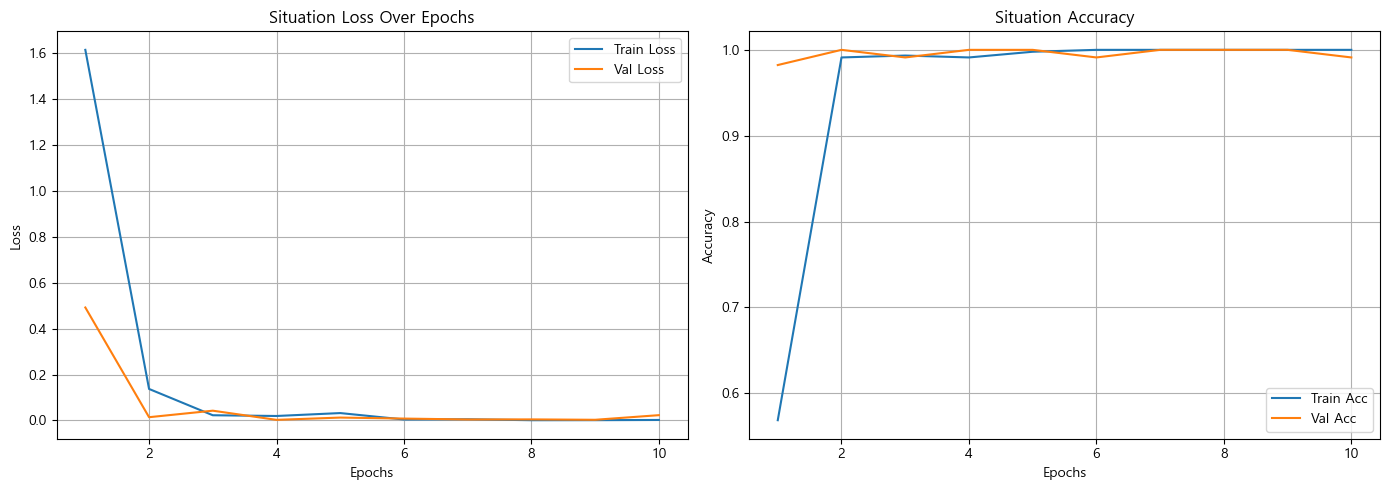

In [210]:
plot_history(history_situation_eff, title_prefix="Situation")

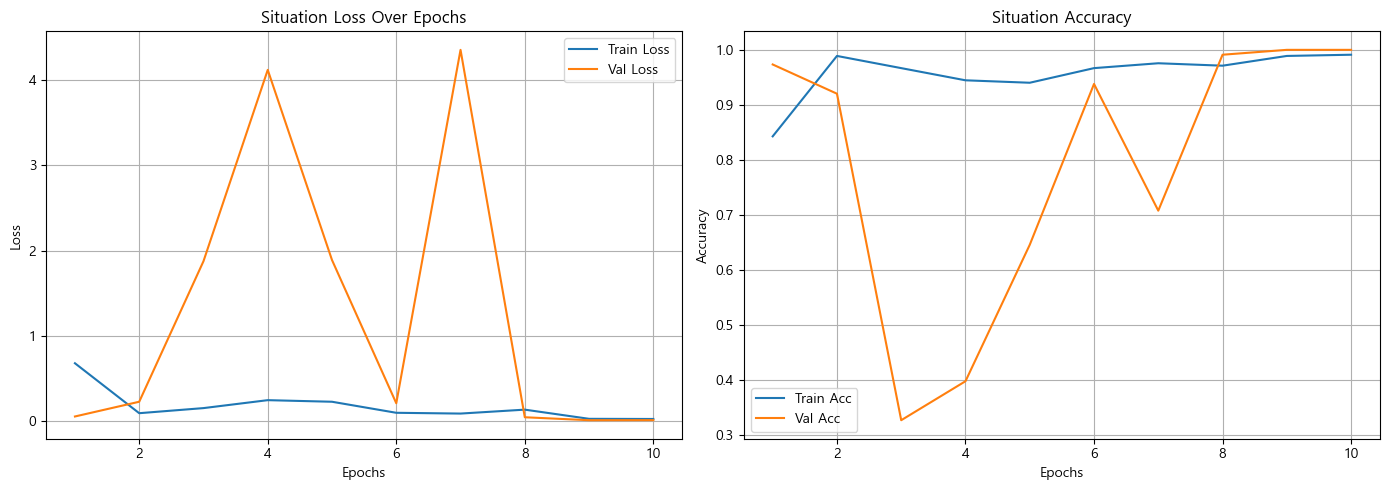

In [186]:
plot_history(history_situation_res50, title_prefix="Situation")

#### **TEST!**

In [235]:
def get_test_dataloader_from_folder(
    image_root,
    batch_size=32,
    label_mapper=None
):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    test_dataset = FolderLabelDataset(
        image_root=image_root,
        transform=transform,
        label_mapper=label_mapper
    )

    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader, test_dataset

In [236]:
from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(model, test_loader, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Test Accuracy: {acc:.2f}")
    print(f"Test F1 Score: {f1:.2f}")

    return acc, f1

In [243]:
# 감정 테스트셋 로딩
test_loader_emotion, test_dataset_emotion = get_test_dataloader_from_folder(
    image_root=r"C:\Users\yura\Desktop\AI\emotion_test_faces", 
    batch_size=32
)

# 상황 테스트셋 로딩
# test_loader_situation, test_dataset_situation = get_test_dataloader_from_folder(
#     image_root=r"C:\Users\yura\Desktop\AI\situation_test",  
#     batch_size=32,
#     label_mapper=map_situation
# )

In [285]:
# acc, f1 = evaluate_model(model_emotion, test_loader_emotion, class_names_emotion)
# acc, f1 = evaluate_model(model_emotion_res50, test_loader_emotion, class_names_emotion)
acc, f1 = evaluate_model(model_emotion_eff, test_loader_emotion, class_names_emotion)
acc, f1 = evaluate_model(model_emotion_eff_yolo, test_loader_emotion, class_names_emotion)

Test Accuracy: 0.51
Test F1 Score: 0.50
Test Accuracy: 0.99
Test F1 Score: 0.99


In [ ]:
# acc, f1 = evaluate_model(model_situation, test_loader_situation, class_names_situation)
# acc, f1 = evaluate_model(model_situation_eff, test_loader_situation, class_names_situation)
acc, f1 = evaluate_model(model_situation_res50, test_loader_situation, class_names_situation)

Test Accuracy: 1.00
Test F1 Score: 1.00


#### **기타**

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

def plot_confusion_matrix(model, test_loader, class_names, normalize=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(
        all_labels,
        all_preds,
        labels=list(range(len(class_names))),
        normalize='true' if normalize else None
    )

    fig, ax = plt.subplots(figsize=(8, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap="Blues", colorbar=False)

    ax.set_xticklabels(class_names, rotation=45, ha='right') 
    ax.set_title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

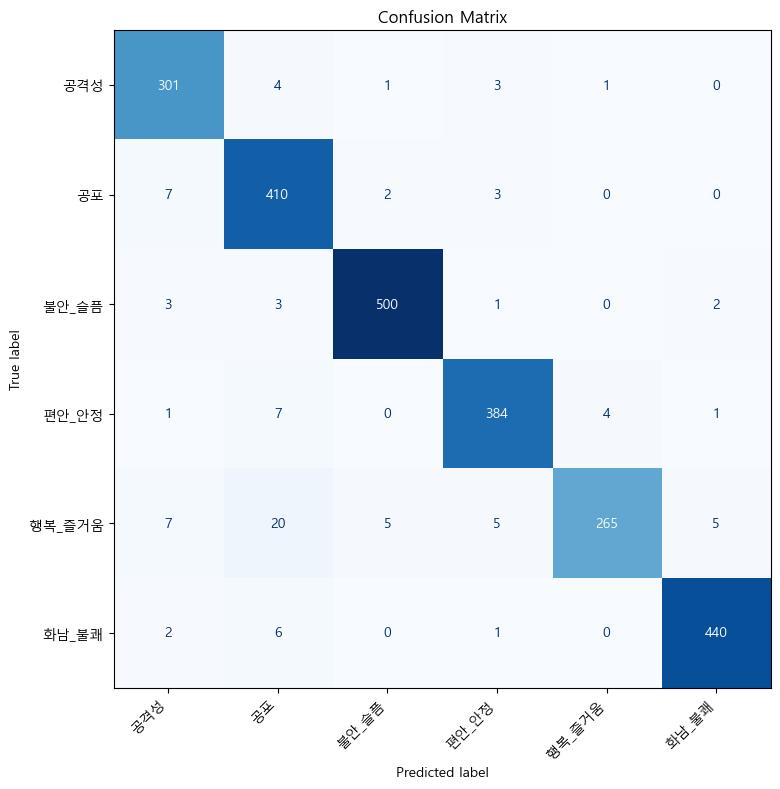

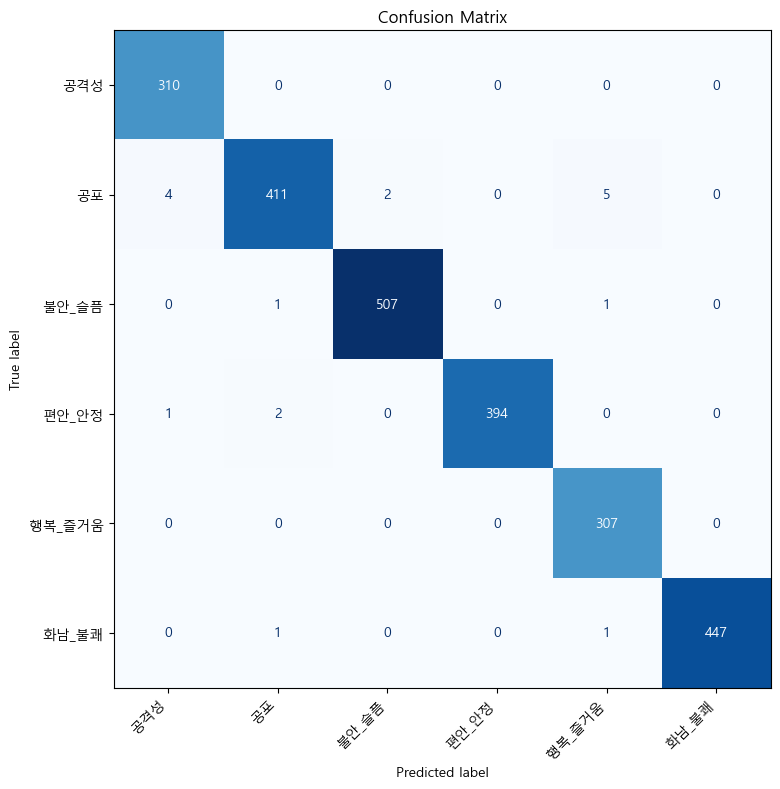

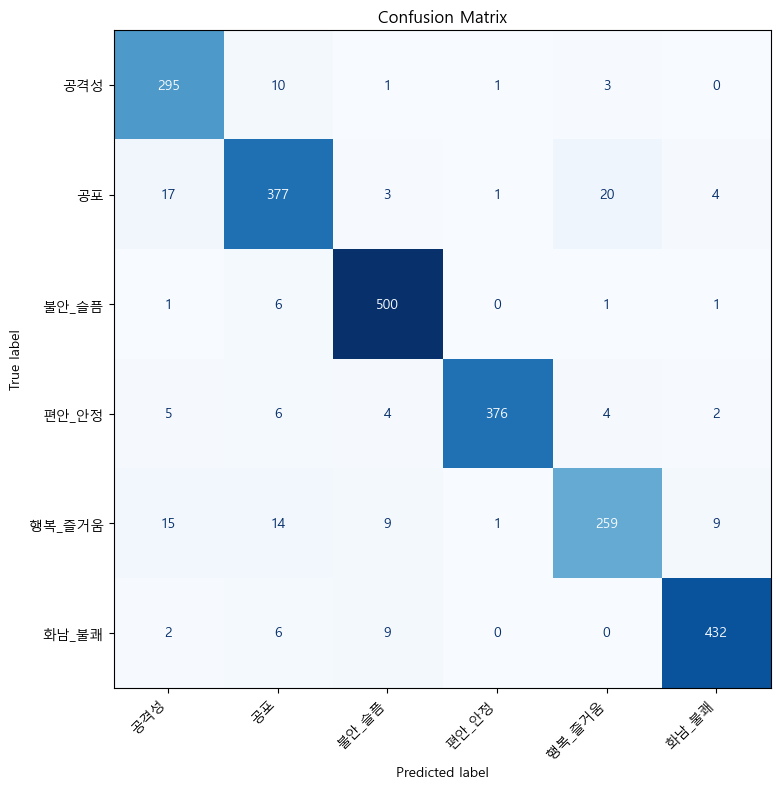

In [245]:
plt.rcParams['font.family'] = 'Malgun Gothic' # 한글 폰트 설정 
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# Emotion
plot_confusion_matrix(model_emotion, test_loader_emotion, class_names=class_names_emotion)
plot_confusion_matrix(model_emotion_eff, test_loader_emotion, class_names=class_names_emotion)
plot_confusion_matrix(model_emotion_res50, test_loader_emotion, class_names=class_names_emotion)


# Situation
# plot_confusion_matrix(model_situation, test_loader_situation, class_names=class_names_situation)
# plot_confusion_matrix(model_situation_eff, test_loader_situation, class_names=class_names_situation)
# plot_confusion_matrix(model_situation_res50, test_loader_situation, class_names=class_names_situation)

#### **Inference**

In [188]:
import os
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

class InferenceImageDataset(Dataset):
    def __init__(self, image_root, transform=None):
        self.image_paths = [
            os.path.join(image_root, fname)
            for fname in sorted(os.listdir(image_root))
            if fname.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, img_path


# Inference 함수
def run_inference(model, image_root, class_names):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # transform과 dataset 정의를 내부로 이동
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    dataset = InferenceImageDataset(image_root=image_root, transform=transform)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    results = []

    if len(dataset) == 0:
        print("❌ 이미지가 없습니다. 경로를 확인하세요.")
        return

    with torch.no_grad():
        for img, img_path in tqdm(dataloader):
            img = img.to(device)
            output = model(img)
            prob = F.softmax(output, dim=1)
            pred_idx = prob.argmax(dim=1).item()
            confidence = prob[0, pred_idx].item()
            vector = prob[0].cpu().numpy()

            results.append({
                "filename": os.path.basename(img_path[0]),
                "class_idx": pred_idx,
                "class": class_names[pred_idx],
                "prob": confidence,
                "vector": vector,
                "path": img_path[0]
            })

    # 최빈 클래스 추출
    class_list = [r['class'] for r in results]
    final_class = Counter(class_list).most_common(1)[0][0]
    print(f"\n최종 예측 클래스: {final_class}")

    print("클래스별 예측 개수 요약:")
    print("==========================")
    for cls, count in Counter(class_list).items():
        print(f"{cls:<15} : {count}장")

    # 대표 이미지 선택
    final_class_results = [r for r in results if r['class'] == final_class]
    mean_vector = np.mean([r['vector'] for r in final_class_results], axis=0).reshape(1, -1)
    best_match = max(final_class_results, key=lambda r: cosine_similarity(r['vector'].reshape(1, -1), mean_vector)[0][0])

    print(f"\n대표 이미지: {best_match['filename']} (확률: {best_match['prob']:.4f})")
    img = Image.open(best_match['path'])
    original_width, original_height = img.size
    resized_img = img.resize((original_width // 2, original_height // 2))
    display(resized_img)

    return results


100%|██████████| 29/29 [00:00<00:00, 97.64it/s]


최종 예측 클래스: 공포
클래스별 예측 개수 요약:
공포              : 18장
공격성             : 4장
편안_안정           : 4장
행복_즐거움          : 3장

대표 이미지: frame_432_timestamp_14400.jpg (확률: 0.7985)


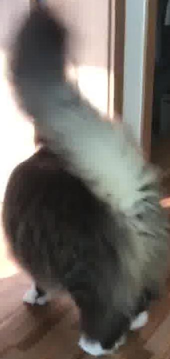

100%|██████████| 29/29 [00:00<00:00, 72.57it/s]


최종 예측 클래스: 행복_즐거움
클래스별 예측 개수 요약:
공격성             : 6장
행복_즐거움          : 12장
공포              : 5장
편안_안정           : 6장

대표 이미지: frame_114_timestamp_3800.jpg (확률: 0.8804)


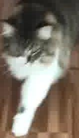

100%|██████████| 29/29 [00:00<00:00, 149.26it/s]


최종 예측 클래스: 공포
클래스별 예측 개수 요약:
공포              : 25장
불안_슬픔           : 1장
공격성             : 2장
행복_즐거움          : 1장

대표 이미지: frame_114_timestamp_3800.jpg (확률: 0.9279)


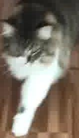

[{'filename': 'frame_102_timestamp_3400.jpg',
  'class_idx': 1,
  'class': '공포',
  'prob': 0.9887431859970093,
  'vector': array([   0.011256,     0.98874,  4.4987e-07,  5.3419e-08,  8.9047e-09,  4.2664e-07], dtype=float32),
  'path': 'C:\\Users\\yura\\Desktop\\AI\\Inference_faces\\New\\12\\frame_102_timestamp_3400.jpg'},
 {'filename': 'frame_108_timestamp_3600.jpg',
  'class_idx': 1,
  'class': '공포',
  'prob': 0.9966905117034912,
  'vector': array([  0.0032807,     0.99669,  1.0766e-06,  2.5826e-06,  2.4414e-05,  7.1933e-07], dtype=float32),
  'path': 'C:\\Users\\yura\\Desktop\\AI\\Inference_faces\\New\\12\\frame_108_timestamp_3600.jpg'},
 {'filename': 'frame_114_timestamp_3800.jpg',
  'class_idx': 1,
  'class': '공포',
  'prob': 0.9278594255447388,
  'vector': array([   0.070847,     0.92786,  5.4114e-05,  0.00044028,  0.00068124,   0.0001181], dtype=float32),
  'path': 'C:\\Users\\yura\\Desktop\\AI\\Inference_faces\\New\\12\\frame_114_timestamp_3800.jpg'},
 {'filename': 'frame_120_tim

In [267]:
# Inference 

# image_root = r"C:\Users\yura\Desktop\AI\Inference_faces\cat\home"
image_root = r"C:\Users\yura\Desktop\AI\Inference_faces\New\12"

run_inference(model_emotion, image_root, class_names_emotion)
# run_inference(model_situation, image_root, class_names_situation)

run_inference(model_emotion_eff, image_root, class_names_emotion)
# run_inference(model_situation_eff, image_root, class_names_situation)

run_inference(model_emotion_res50, image_root, class_names_emotion)
# run_inference(model_situation_res50, image_root, class_names_situation)


In [293]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

def generate_gradcam(model, image_path, class_names, target_layer_name=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    if target_layer_name is None:
        model_name = model.__class__.__name__.lower()
        if 'efficientnet' in model_name:
            target_layer_name = 'features.6'
        elif 'resnet' in model_name:
            target_layer_name = 'layer4'
        else:
            raise ValueError(f"Error!: {model_name}")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    image = Image.open(image_path).convert('RGB')
    original_size = image.size
    input_tensor = transform(image).unsqueeze(0).to(device)

    activations, gradients = {}, {}

    def forward_hook(module, input, output):
        activations['value'] = output

    def backward_hook(module, grad_input, grad_output):
        gradients['value'] = grad_output[0]

    # 📌 Hook 등록
    for name, module in model.named_modules():
        if name == target_layer_name:
            module.register_forward_hook(forward_hook)
            module.register_backward_hook(backward_hook)
            break

    # Forward & Backward
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()
    print(f"예측 클래스: {class_names[pred_class]}")

    model.zero_grad()
    output[0, pred_class].backward()

    # Grad-CAM 계산
    fmap = activations['value']
    grads = gradients['value']
    weights = grads.mean(dim=(2, 3), keepdim=True)
    gradcam = F.relu((weights * fmap).sum(dim=1, keepdim=True))
    gradcam = F.interpolate(gradcam, size=(original_size[1], original_size[0]), mode='bilinear', align_corners=False)
    gradcam = gradcam.squeeze().cpu().detach().numpy()
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min() + 1e-8)

    # 시각화
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.imshow(gradcam, cmap='jet', alpha=0.5, interpolation='bilinear')
    plt.title(f"Grad-CAM: {class_names[pred_class]}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


c:\Users\yura\Desktop\coder\venv\lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


예측 클래스: 화남_불쾌


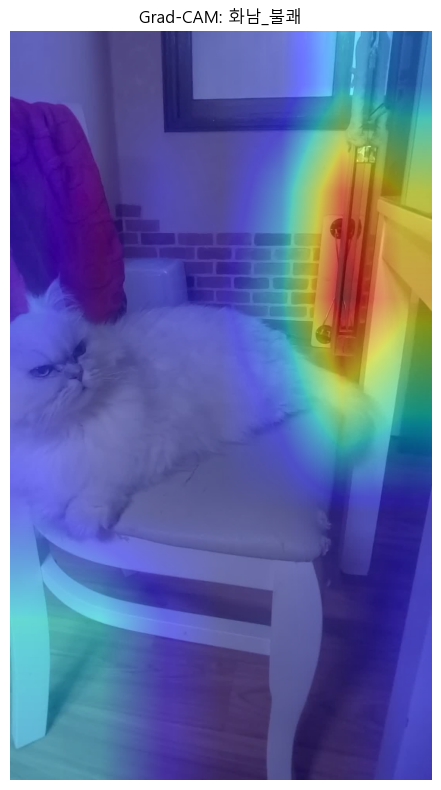

예측 클래스: 불안_슬픔


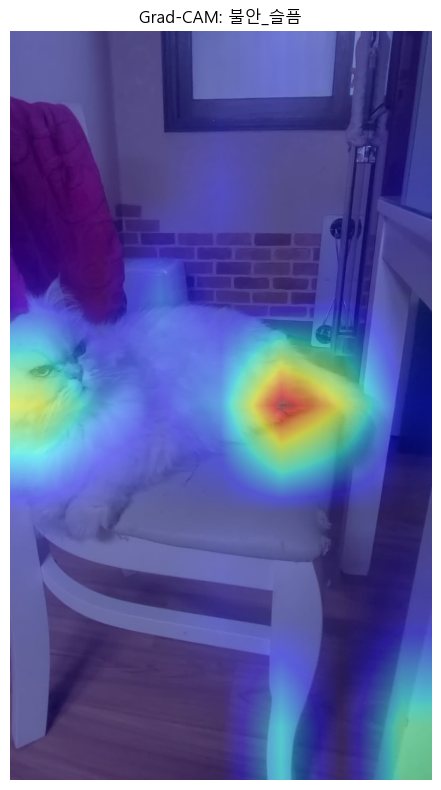

예측 클래스: 공격성


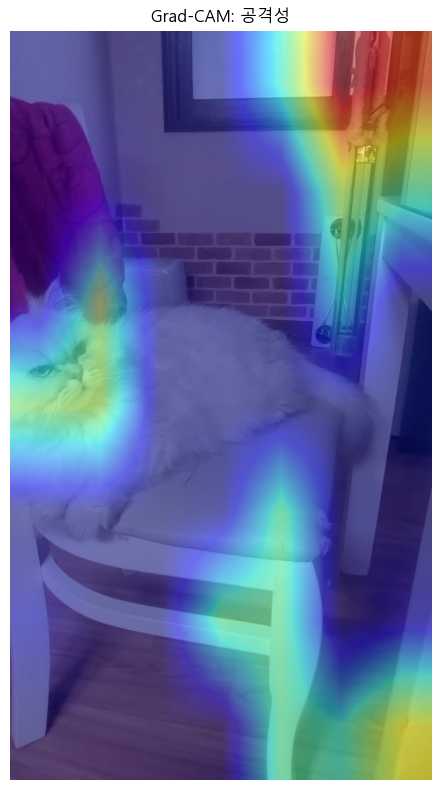

예측 클래스: 행복_즐거움


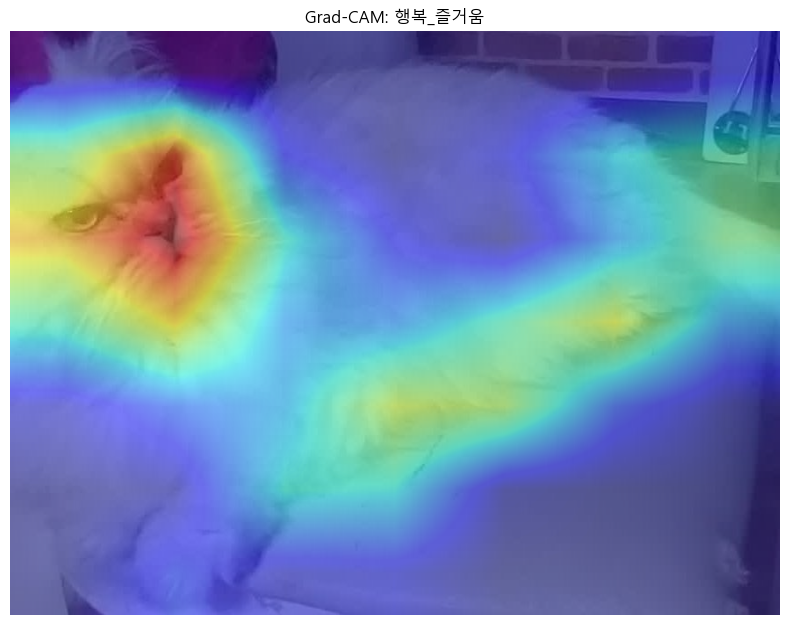

In [295]:
image_root = r"C:\Users\yura\Desktop\AI\Inference\New\9\frame_6_timestamp_200.jpg"
image_root_faces = r"C:\Users\yura\Desktop\AI\Inference_faces\New\9\frame_6_timestamp_200.jpg"

generate_gradcam(model_emotion, image_root, class_names_emotion)
generate_gradcam(model_emotion_res50, image_root, class_names_emotion)
generate_gradcam(model_emotion_eff, image_root, class_names_emotion)
generate_gradcam(model_emotion_eff_yolo, image_root_faces, class_names_emotion)
